# Modelo de reservas de seguros comerciales

## Entendimiento de los datos

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import time
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Los datos estan disponibles en :**

https://www.casact.org/publications-research/research/research-resources/loss-reserving-data-pulled-naic-schedule-p

In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/TercerTrimestre/machine_learning/autos.csv')

df 

In [ ]:
df.shape

(15800, 13)

### Interpretación de una observación

In [ ]:
df[df["GRCODE"] == 44598].iloc[0]

GRCODE                                          44598
GRNAME               College Liability Ins Co Ltd RRG
AccidentYear                                     1988
DevelopmentYear                                  1988
DevelopmentLag                                      1
IncurLoss_C                                        74
CumPaidLoss_C                                      15
BulkLoss_C                                         39
EarnedPremDIR_C                                   117
EarnedPremCeded_C                                   0
EarnedPremNet_C                                   117
Single                                              1
PostedReserve97_C                                 248
Name: 15700, dtype: object

### Resumen numérico

In [ ]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15800 entries, 0 to 15799
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   GRCODE             15800 non-null  int64 
 1   GRNAME             15800 non-null  object
 2   AccidentYear       15800 non-null  int64 
 3   DevelopmentYear    15800 non-null  int64 
 4   DevelopmentLag     15800 non-null  int64 
 5   IncurLoss_C        15800 non-null  int64 
 6   CumPaidLoss_C      15800 non-null  int64 
 7   BulkLoss_C         15800 non-null  int64 
 8   EarnedPremDIR_C    15800 non-null  int64 
 9   EarnedPremCeded_C  15800 non-null  int64 
 10  EarnedPremNet_C    15800 non-null  int64 
 11  Single             15800 non-null  int64 
 12  PostedReserve97_C  15800 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.6+ MB


### Resumen gráfico

La interpretación del gráfico de correlaciones previamente presentado arroja luz sobre las relaciones existentes entre las diversas variables. Se observa una tendencia predominante de baja correlación entre la mayoría de las variables, destacándose, sin embargo, algunas excepciones notables. En particular, se evidencian conexiones significativas entre pares específicos de variables, tales como (EarnedPremNet_C, PostedReserve97_C), (EarnedPremDIR_C, PostedReserve97_C), y (EarnedPremDIR_C, EarnedPremNet_C), entre otras instancias.

Ahondando en el análisis, la atención se centra ahora en la gráfica que representa las columnas AccidentYear, DevelopmentYear, IncurLoss_C y CumPaidLoss_C, consideradas de alta relevancia para el cálculo de reservas. Uno de los hallazgos más notables es la aparente relación que se vislumbra entre IncurLoss_C y CumPaidLoss_C, sugiriendo una conexión que podría tener implicaciones significativas en el ámbito del cálculo de reservas.

Por otro lado, es interesante señalar que, a pesar de la importancia atribuida a estas columnas clave, no se revela de manera clara alguna relación apreciable entre las demás variables representadas en la gráfica. Este descubrimiento resalta la complejidad inherente en la interacción de estas variables y la necesidad de un análisis más detenido para comprender plenamente las dinámicas subyacentes en el contexto del cálculo de reservas. En consecuencia, estos insights no solo proporcionan una visión más profunda de las relaciones identificadas, sino que también orientan hacia áreas específicas que pueden requerir una atención más detallada en futuros análisis y modelados.

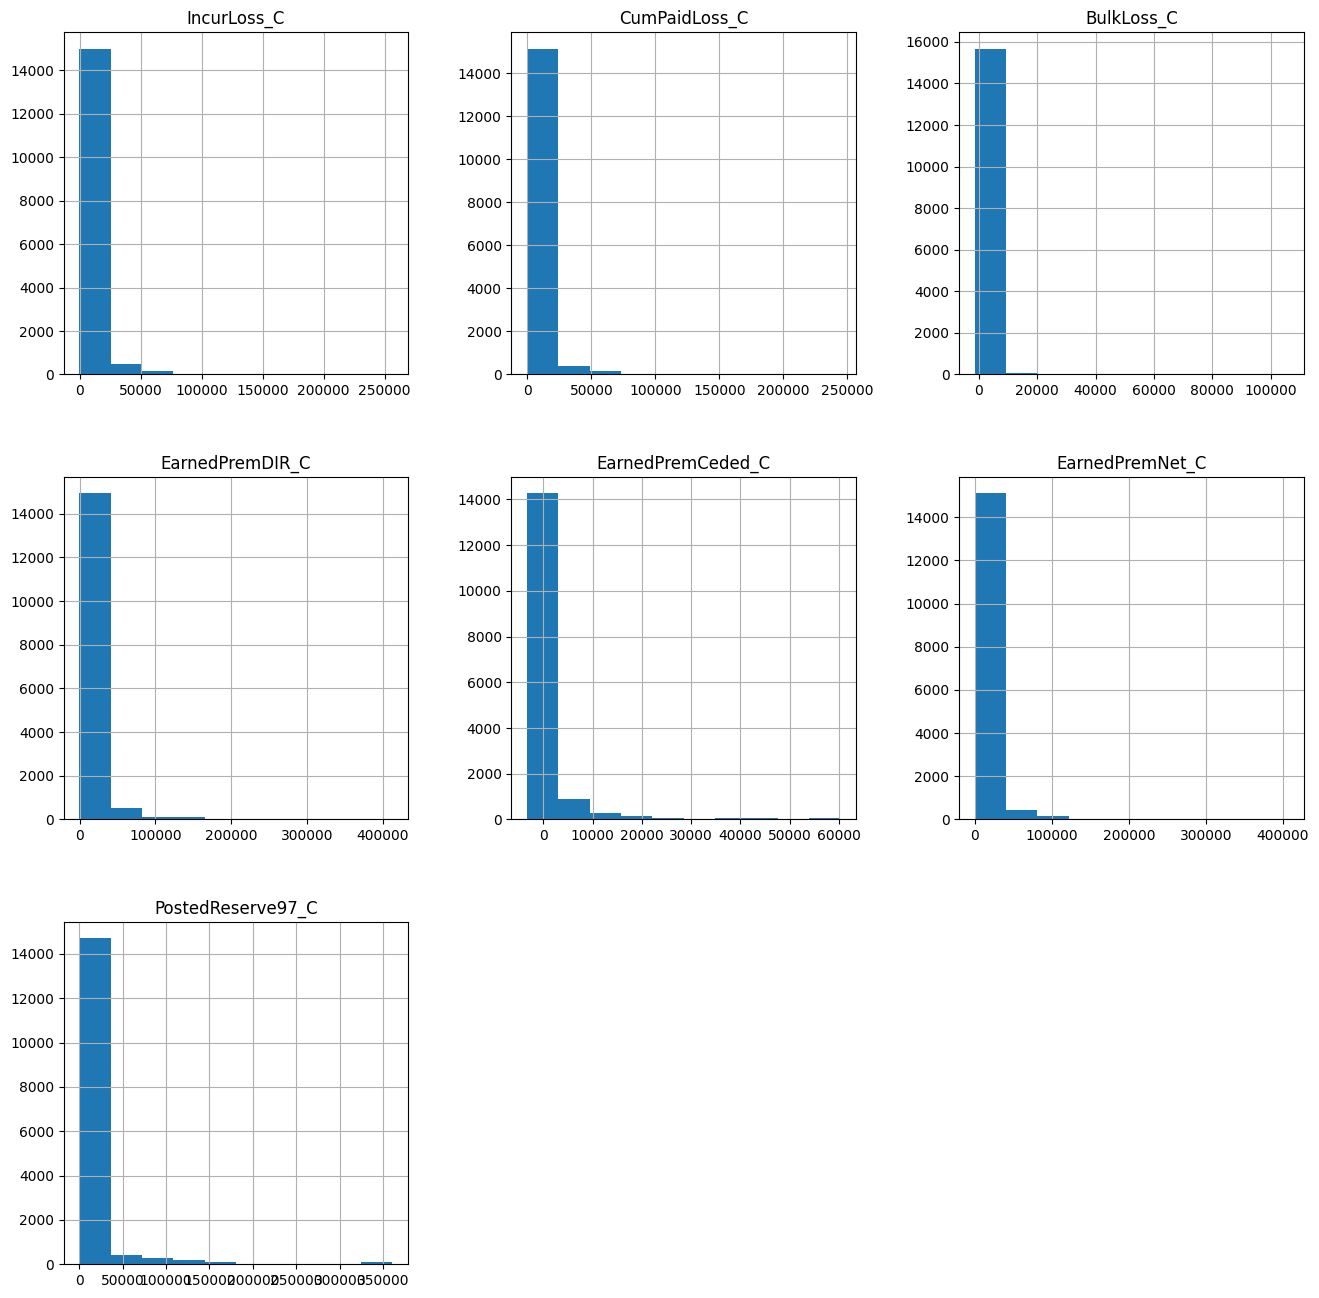

In [ ]:
df[['IncurLoss_C', 'CumPaidLoss_C', 'BulkLoss_C', 'EarnedPremDIR_C','EarnedPremCeded_C', 'EarnedPremNet_C', 'PostedReserve97_C']].hist(figsize=(16,16))
plt.show()

## Procesamiento de los datos

In [ ]:
df_col_seleccionado = df.columns[0:6] #se selecionan las columnas más importantes
df_col_seleccionado

Index(['GRCODE', 'GRNAME', 'AccidentYear', 'DevelopmentYear', 'DevelopmentLag',
       'IncurLoss_C'],
      dtype='object')

In [1]:
Lista_entidades_ceros = df[df[df_col_seleccionado[5]] <= 0]["GRCODE"].unique()
df_filtrado = df[~df["GRCODE"].isin(Lista_entidades_ceros)] #se filtra la tabla de datos
df_filtrado[df_filtrado[df_col_seleccionado[5]] <= 0]["GRCODE"].unique() #Verificación debe estar en vacío
df_filtrado = df_filtrado[df_col_seleccionado] #se guarda el df filtrado sin errores
print("Cantida:", len(df_filtrado["GRCODE"].unique()))

NameError: name 'df' is not defined

## Modelado


Entre los algoritmos que conforman el conjunto de procesos, destaca notablemente aquel que presenta el mayor tiempo de ejecución individual. Este fenómeno repercute significativamente en el proceso global de cross-validation, ya que los modelos lineales dependen intrínsecamente del algoritmo de chain-ladder. La razón subyacente radica en que dicho algoritmo se encarga de proporcionar los triángulos de reserva específicos de cada aseguradora o de un conjunto predeterminado de aseguradoras. Esta dependencia del algoritmo de chain-ladder, que se caracteriza por su prolongado tiempo de ejecución, impone una demora sustancial en la realización efectiva del proceso de cross-validation, añadiendo complejidad y consideraciones temporales al análisis general del conjunto de datos.

In [ ]:
class ChainLadder: #clase se cálcula el Chain-Ladder
    def __init__(self, tabla = pd.DataFrame(), origin = "", development = "", columns = "", index = ""):

        self.tabla = tabla #OK
        self.origin = origin #OK
        self.development = development #OK
        self.index = index #OK
        self.columns = columns #OK

    def Triangulos(self):

        # Renombrar las columnas
        datos = self.tabla.rename(columns={self.origin: "AccidentYear", self.development: "DevelopmentLag", self.columns: "IncurLoss_C",
                                          self.index: "GRCODE"})

        diccionario_todos_triangulos = {}

        for k in datos["GRCODE"].unique():


            Filtro_datos = datos[datos["GRCODE"] == k] #se filtran los datos filtra por aseguradora

            #se crean los triangulos
            Triangulo_full = Filtro_datos.pivot_table(values = "IncurLoss_C", index = "AccidentYear", columns='DevelopmentLag', aggfunc="sum", margins=False)
            #se crea una copia
            Triangulo_full_acumulado = Triangulo_full.copy()
            #se guarda el numero de filas y columnas del triangulo
            num_filas = Triangulo_full_acumulado.shape[0]
            num_columnas = Triangulo_full_acumulado.shape[1]
            #se eliminan los datos del triangulo inferior
            Triangulo_full_mitad = Triangulo_full.copy()
            for i in range(num_filas):
                for j in range(1,i+1):
                    Triangulo_full_mitad.iloc[i, -j] = None  # Puedes establecerlo en None u otro valor si lo prefieres
            #se suman las columnas para hallar el tirangulo acumulado
            for indice, i in enumerate(range(1,num_columnas+1)):
                Triangulo_full_acumulado[Triangulo_full.columns[indice]] = Triangulo_full[Triangulo_full.columns[0:i]].sum(axis = 1)
            #se halla eliminan datos del triangulo inferior del triangulo acumulado
            Triangulo_acumulado_mitad = Triangulo_full_acumulado.copy()
            for i in range(num_filas):
                for j in range(1,i+1):
                    Triangulo_acumulado_mitad.iloc[i, -j] = None  # Puedes establecerlo en None u otro valor si lo prefieres
            #se calculan los factores
            factores0 = Triangulo_acumulado_mitad.sum(axis = 0) # Rojo
            factores1 = Triangulo_acumulado_mitad.sum(axis = 0)-np.flip(np.diag(np.fliplr(Triangulo_acumulado_mitad), 0)) # Azul
            factores0 = factores0[1:10]
            factores1 = factores1[0:-1]
            factores = factores0.reset_index(drop = True) / factores1.reset_index(drop = True)
            #se estima el triangulo por chain-ladder
            Triangulo_estimado = Triangulo_acumulado_mitad.copy()
            for i in list(reversed(range(num_filas))):
                comodin = np.diag(np.fliplr(Triangulo_acumulado_mitad), 0)[i]
                for j in range(1,i+1):
                    Triangulo_estimado.iloc[i, -j] = comodin*factores.iloc[-i+9:-j+10].prod()   # Puedes establecerlo en None u otro valor si lo prefieres


            #se calcula la reserva
            reserva_total = sum(np.array(list(reversed(np.array(Triangulo_estimado[10]))))-np.flip(np.diag(np.fliplr(Triangulo_estimado), 0)))
            #se crea diccionario que va ser el resultado final
            diciconario_triangulo = {'Triangulo_full':Triangulo_full, "Triangulo_full_mitad":Triangulo_full_mitad, "Triangulo_full_acumulado":Triangulo_full_acumulado,
                                     "Triangulo_acumulado_mitad":Triangulo_acumulado_mitad, "factores":factores, "Triangulo_estimado":Triangulo_estimado,
                                     "reserva_total":reserva_total}

            nombre = k
            diccionario_todos_triangulos[nombre] = diciconario_triangulo

        return diccionario_todos_triangulos



In [ ]:
class ChainLadder_corto: 
    def __init__(self, tabla = pd.DataFrame(), origin = "", development = "", columns = "", index = ""):

        self.tabla = tabla #OK
        self.origin = origin #OK
        self.development = development #OK
        self.index = index #OK
        self.columns = columns #OK

    def Triangulos(self):

        datos = self.tabla.rename(columns={self.origin: "AccidentYear", self.development: "DevelopmentLag", self.columns: "IncurLoss_C",
                                          self.index: "GRCODE"})

        diccionario_todos_triangulos = {}

        for k in datos["GRCODE"].unique():

            Filtro_datos = datos[datos["GRCODE"] == k]
            Triangulo_full = Filtro_datos.pivot_table(values = "IncurLoss_C", index = "AccidentYear", columns='DevelopmentLag', aggfunc="sum", margins=False)
            Triangulo_full_acumulado = Triangulo_full.copy()
            num_filas = Triangulo_full_acumulado.shape[0]
            num_columnas = Triangulo_full_acumulado.shape[1]
            Triangulo_full_mitad = Triangulo_full.copy()
            for i in range(num_filas):
                for j in range(1,i+1):
                    Triangulo_full_mitad.iloc[i, -j] = None  
            diciconario_triangulo = {'Triangulo_full':Triangulo_full, "Triangulo_full_mitad":Triangulo_full_mitad}

            nombre = k
            diccionario_todos_triangulos[nombre] = diciconario_triangulo

        return diccionario_todos_triangulos

# ChainLadder

In [2]:
code_aseguradora = df_filtrado["GRCODE"].unique()[0] 

NameError: name 'df_filtrado' is not defined

In [ ]:
resultados = ChainLadder(tabla = df_filtrado, origin = "AccidentYear", development = "DevelopmentLag", columns = df_filtrado.columns[5], index = "GRCODE")
triangulos_resultados = resultados.Triangulos()

In [ ]:
triangulos_resultados[code_aseguradora]["Triangulo_full_acumulado"] 

DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,4144,7278,9114,10816,12775,14734,16689,18495,20288,22070
1989,2727,5070,7070,9019,10968,12898,14373,15840,17285,18727
1990,2470,4972,6572,8173,9729,10631,11530,12416,13303,14185
1991,2092,4101,6195,8228,9084,9919,10734,11548,12364,13183
1992,1360,2583,3767,4364,4960,5533,6105,6678,7260,7846
1993,413,790,1015,1241,1440,1640,1838,2045,2250,2440
1994,193,319,480,620,762,900,1046,1193,1321,1454
1995,102,283,433,577,718,868,1017,1147,1281,1409
1996,75,192,299,407,516,656,774,884,994,1105


In [ ]:
triangulos_resultados[code_aseguradora]["Triangulo_full_mitad"] 

DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,4144,3134.0,1836.0,1702.0,1959.0,1959.0,1955.0,1806.0,1793.0,1782.0
1989,2727,2343.0,2000.0,1949.0,1949.0,1930.0,1475.0,1467.0,1445.0,NaN
1990,2470,2502.0,1600.0,1601.0,1556.0,902.0,899.0,886.0,NaN,NaN
1991,2092,2009.0,2094.0,2033.0,856.0,835.0,815.0,NaN,NaN,NaN
1992,1360,1223.0,1184.0,597.0,596.0,573.0,NaN,NaN,NaN,NaN
1993,413,377.0,225.0,226.0,199.0,NaN,NaN,NaN,NaN,NaN
1994,193,126.0,161.0,140.0,NaN,NaN,NaN,NaN,NaN,NaN
1995,102,181.0,150.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1996,75,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Triangulo estimado completo.

In [ ]:
triangulos_resultados[code_aseguradora]["Triangulo_estimado"] 

DevelopmentLag,1,2,3,4,5,6,7,8,9,10
AccidentYear,,,,,,,,,,
1988,4144,7278.000000,9114.000000,10816.000000,12775.000000,14734.000000,16689.000000,18495.000000,20288.000000,22070.000000
1989,2727,5070.000000,7070.000000,9019.000000,10968.000000,12898.000000,14373.000000,15840.000000,17285.000000,18803.230974
1990,2470,4972.000000,6572.000000,8173.000000,9729.000000,10631.000000,11530.000000,12416.000000,13586.904558,14780.312677
1991,2092,4101.000000,6195.000000,8228.000000,9084.000000,9919.000000,10734.000000,11782.147680,12893.276097,14025.759240
1992,1360,2583.000000,3767.000000,4364.000000,4960.000000,5533.000000,6123.713378,6721.678347,7355.573628,8001.651714
1993,413,790.000000,1015.000000,1241.000000,1440.000000,1627.864298,1801.658121,1977.585434,2164.083807,2354.166484
1994,193,319.000000,480.000000,620.000000,725.430081,820.070645,907.622914,996.249973,1090.202424,1185.960543
1995,102,283.000000,433.000000,537.386754,628.768574,710.798551,786.684727,863.502482,944.936034,1027.934655
1996,75,192.000000,261.932273,325.078369,380.357463,429.979400,475.884801,522.353736,571.614880,621.822772


In [ ]:
triangulos_resultados[code_aseguradora]["reserva_total"] 

12173.360140170096

# Regresion lineal, Lasso y Ridge.

In [ ]:
class Reserva_Regresion_lineal:
    def __init__(self, tabla = pd.DataFrame(), origin = "", development = "", columns = "", index = "", alpha = 1, matriz_de_ceros = pd.DataFrame()):

        self.tabla = tabla 
        self.origin = origin
        self.development = development
        self.index = index
        self.columns = columns 
        self.alpha = alpha 
        self.matriz_de_ceros = matriz_de_ceros 


    def Regresion_lineal(self):

    
        datos = self.tabla.rename(columns={self.origin: "AccidentYear", self.development: "DevelopmentLag", self.columns: "IncurLoss_C",
                                          self.index: "GRCODE"})
        inicio = time.time()

        resultados = ChainLadder_corto(tabla = datos, origin = "AccidentYear", development = "DevelopmentLag", columns = "IncurLoss_C", index = "GRCODE")
        triangulos_resultados = resultados.Triangulos()
        fin = time.time()
        #print(fin-inicio)

        #triangulos_resultados

        inicio = time.time()
        Y = pd.DataFrame()
        Y_completo = pd.DataFrame()
        matriz_X = pd.DataFrame()
      
        for i in datos["GRCODE"].unique():#[3492]:#
            triangulo = triangulos_resultados[i]["Triangulo_full_mitad"]
            triangulo_completo = triangulos_resultados[i]["Triangulo_full"]
            triangulo_log =  np.log(triangulo) #se aplica logaritmo a los datos
            triangulo_completo_log = np.log(triangulo_completo) #se aplica logaritmo a los datos
            vector_Y = pd.melt(triangulo_log)
            vector_Y_completo = pd.melt(triangulo_completo_log)
            vector_Y["GRCODE"] = i
            Y = pd.concat([Y,vector_Y], axis = 0)
            Y_completo = pd.concat([Y_completo,vector_Y_completo], axis = 0)
            matriz_X = pd.concat([matriz_X, self.matriz_de_ceros], axis = 0)

        fin = time.time()

        inicio = time.time()

        matriz_X = matriz_X.reset_index(drop=True)
        Y = Y.reset_index(drop=True)
        Y_completo = Y_completo.reset_index(drop=True)
        Y_completo = Y_completo[["value"]]
        Y_completo.columns = ["value_completo"]

        matriz_regresion = pd.concat([Y[["value", "GRCODE"]], Y_completo, matriz_X], axis = 1)
        matriz_regresion = matriz_regresion.reset_index(drop=True)
        matriz_regresion1 = matriz_regresion[~matriz_regresion["value"].isnull()]
        #se cambian los nombres por lo nombres correctos de los parametros
        matriz_regresion1.columns = ['Z', "GRCODE", "Z_completo", "u", "alpha1", "alpha2", "alpha3", "alpha4", "alpha5",
                                    "alpha6", "alpha7", "alpha8", "alpha9", "beta1", "beta2", "beta3",
                                    "beta4", "beta5", "beta6", "beta7", "beta8", "beta9"]
        matriz_regresion1 = matriz_regresion1.reset_index(drop=True)
        X = matriz_regresion1.iloc[:,3:]
        Y = matriz_regresion1.iloc[:,0]

        coeficientes = {"Coef_normal":self.B, "Coef_ridge1":self.B_ridge_1, "Coef_lasso":self.B_lasso}

        #diccionario_resultados = {"Metricas MSE":metricas_MSE, "Metricas MAPE":metricas_MAPE, "coeficientes":coeficientes ,"Comparacion":comparacion, "X":X}
        diccionario_resultados = {"coeficientes":coeficientes, "X":X}
        return diccionario_resultados

    def predict(self, datos_new):


        datos_new = datos_new.rename(columns={self.origin: "AccidentYear", self.development: "DevelopmentLag", self.columns: "IncurLoss_C",
                                          self.index: "GRCODE"})
        #se aplica el algoritmo de chain-ladder corto para poder entrenar los modelos
        resultados = ChainLadder_corto(tabla = datos_new, origin = "AccidentYear", development = "DevelopmentLag", columns = "IncurLoss_C", index = "GRCODE")

        triangulos_resultados = resultados.Triangulos()

        i = datos_new["GRCODE"].unique()[0]#[3492]:# Se filtran los datos para la aseguradora de validación
        triangulo = triangulos_resultados[i]["Triangulo_full_mitad"] #se calcula triangulo de arriba
        triangulo_completo = triangulos_resultados[i]["Triangulo_full"] #se calcula triangulo completo o matriz completa
        triangulo_log =  np.log(triangulo) #se saca logaritmo a los datos
        triangulo_completo_log = np.log(triangulo_completo) #se saca logaritmo a los datos
        vector_Y = pd.melt(triangulo_log) #se pasa el triangulo a vector
        vector_Y_completo = pd.melt(triangulo_completo_log) #se pasa el triangulo a vector
        vector_Y["GRCODE"] = i
        Y = vector_Y
        Y_completo = vector_Y_completo

        Y = Y.reset_index(drop=True)
        Y_completo = Y_completo.reset_index(drop=True)
        Y_completo = Y_completo[["value"]]
        Y_completo.columns = ["value_completo"]

        X = self.matriz_de_ceros

        matriz_new = pd.concat([Y[["value", "GRCODE"]], Y_completo, X], axis = 1)
        matriz_new = matriz_new.reset_index(drop=True)

        Y_test = matriz_new[matriz_new["value"].isnull()].iloc[:,2] #matriz X de datos
        X_test = matriz_new[matriz_new["value"].isnull()].iloc[:,3:] #vector Y de datos

        comparacion = pd.DataFrame([np.array(Y_test), Y_Ajustado, Y_Ajustado_ridge_1, Y_Ajustado_lasso]).T #Comparacion de Y y Y-ajustado
        comparacion.columns = ["Y_test", "Y_ajustado", "Y_ajustado_ridge_1", "Y_ajustado_lasso"]
        #metrica
        comparacion["GRCODE"] = np.array(i)

        #calculo metrica MSE
        MSE = ((comparacion["Y_test"] - comparacion["Y_ajustado"])**2).mean()
        #MSE_ridge = ((comparacion["Y_test"] - comparacion["Y_ajustado_ridge"])**2).mean()
        MSE_ridge_1 = ((comparacion["Y_test"] - comparacion["Y_ajustado_ridge_1"])**2).mean()
        MSE_lasso = ((comparacion["Y_test"] - comparacion["Y_ajustado_lasso"])**2).mean()

        #calculo metrica MAPE
        MAPE = abs((comparacion["Y_test"] - comparacion["Y_ajustado"])/comparacion["Y_test"]).mean()*100
        #MAPE_ridge = abs((comparacion["Y_test"] - comparacion["Y_ajustado_ridge"])/comparacion["Y_test"]).mean()*100
        MAPE_ridge_1 = abs((comparacion["Y_test"] - comparacion["Y_ajustado_ridge_1"])/comparacion["Y_test"]).mean()*100
        MAPE_lasso = abs((comparacion["Y_test"] - comparacion["Y_ajustado_lasso"])/comparacion["Y_test"]).mean()*100

        metricas_MSE = {"MSE":MSE, "MSE_ridge_1":MSE_ridge_1, "MSE_lasso":MSE_lasso}
        metricas_MAPE = {"MAPE":MAPE, "MAPE_ridge_1":MAPE_ridge_1, "MAPE_lasso":MAPE_lasso}

        coeficientes = {"Coef_normal":self.B, "Coef_ridge1":self.B_ridge_1, "Coef_lasso":self.B_lasso}

        diccionario_resultados_test = {"Metricas MSE":metricas_MSE, "Metricas MAPE":metricas_MAPE, "coeficientes":coeficientes ,"Comparacion":comparacion, "X":X}

        #Acá se escoge el Mejor modelo de los 3 que hay
        metricas_model1 = pd.DataFrame(metricas_MAPE, index = [0]).T
        metricas_model1.index = ['MAPE', 'MAPE_ridge_1', 'MAPE_lasso']
        metricas_model1.columns = ["MAPE"]
        mejor_modelo = metricas_model1[metricas_model1["MAPE"] == metricas_model1["MAPE"].sort_values()[0]]
        #mejor_modelo = str(mejor_modelo.iloc[0,0])
        #print(mejor_modelo.index[0])

        modelo = {'MAPE':self.Regresion_lineal1, 'MAPE_ridge_1':self.ridge_model , 'MAPE_lasso':self.lasso_model}
        coeficientes_orden = {'MAPE':"Coef_normal", 'MAPE_ridge_1':"Coef_ridge1" , 'MAPE_lasso':"Coef_lasso"}
        nombres_orden = {'MAPE':"Regresión normal", 'MAPE_ridge_1':"Regresión de Ridge" , 'MAPE_lasso':"Regresión de Lasso"}
        nombre_mejor_modelo = mejor_modelo.index[0] #mejor modelo

        #resultados mejor modelo
        self.mejor_modelo_resultado = {"nombre mejor modelo":  nombres_orden[nombre_mejor_modelo],
                                       "MAPE mejor modelo":metricas_MAPE[nombre_mejor_modelo],
                                       "coeficientes mejor modelo": coeficientes[coeficientes_orden[nombre_mejor_modelo]],
                                       "mejor modelo":modelo[nombre_mejor_modelo]}
        return diccionario_resultados_test, self.mejor_modelo_resultado

    def predict_test(self, datos_test):

        #inicio = time.time()
        #datos de test
        datos_new = datos_test.rename(columns={self.origin: "AccidentYear", self.development: "DevelopmentLag", self.columns: "IncurLoss_C",
                                          self.index: "GRCODE"})

        #se aplcia la clase chainlader corto
        resultados = ChainLadder_corto(tabla = datos_new, origin = "AccidentYear", development = "DevelopmentLag", columns = "IncurLoss_C", index = "GRCODE")

        triangulos_resultados = resultados.Triangulos()

        i = datos_new["GRCODE"].unique()[0]#[3492]:## 
        triangulo = triangulos_resultados[i]["Triangulo_full_mitad"] #se calcula triangulo de arriba
        triangulo_completo = triangulos_resultados[i]["Triangulo_full"] #se calcula triangulo completo o matriz completa
        triangulo_log =  np.log(triangulo)#se saca logaritmo a los datos
        triangulo_completo_log = np.log(triangulo_completo)#se saca logaritmo a los datos
        vector_Y = pd.melt(triangulo_log)#se pasa el triangulo a vector
        vector_Y_completo = pd.melt(triangulo_completo_log)#se pasa el triangulo a vector
        vector_Y["GRCODE"] = i
        Y = vector_Y
        Y_completo = vector_Y_completo

        Y = Y.reset_index(drop=True)
        Y_completo = Y_completo.reset_index(drop=True)
        Y_completo = Y_completo[["value"]]
        Y_completo.columns = ["value_completo"]

        X = self.matriz_de_ceros

        matriz_new = pd.concat([Y[["value", "GRCODE"]], Y_completo, X], axis = 1)
        matriz_new = matriz_new.reset_index(drop=True)

        Y_test = matriz_new[matriz_new["value"].isnull()].iloc[:,2] #vector Y de datos
        X_test = matriz_new[matriz_new["value"].isnull()].iloc[:,3:] #matriz X de datos

        Y_Ajustado = self.mejor_modelo_resultado["mejor modelo"].predict(X_test)#se ajusta datos de test según el mejor modelo que definió la validación


        comparacion = pd.DataFrame([np.array(Y_test), Y_Ajustado]).T #comparacion entre Y y Y-ajustado
        comparacion.columns = ["Y_test", "Y_ajustado modelo final"]
        #metrica
        comparacion["GRCODE"] = np.array(i)

        #se calcula mse para conjunto de test
        MSE = ((comparacion["Y_test"] - comparacion["Y_ajustado modelo final"])**2).mean()

        #se calcula mape para conjunto de test
        MAPE = abs((comparacion["Y_test"] - comparacion["Y_ajustado modelo final"])/comparacion["Y_test"]).mean()*100
        metricas_MSE = {"MSE modelo final":MSE}
        metricas_MAPE = {"MAPE modelo final":MAPE}

        #coeficientes = {"Coef_normal":self.mejor_modelo_resultado.coef_}

        #se hallan las metricas del mejor modelo para el conjunto de test
        resultados_modelo_final = {"nombre mejor modelo": self.mejor_modelo_resultado["nombre mejor modelo"],
                                   "Metricas MSE": metricas_MSE, "Metricas MAPE":metricas_MAPE,
                                   "coeficientes": self.mejor_modelo_resultado["coeficientes mejor modelo"],
                                   "Comparacion": comparacion, "X":X,
                                   "mejor modelo":self.mejor_modelo_resultado["mejor modelo"]}

        return resultados_modelo_final



In [ ]:
df_filtrado_unico = df_filtrado[df_filtrado["GRCODE"] == df_filtrado["GRCODE"].unique()[0]] #conjunto de validación (una aseguradora)
df_filtrado_unico1 = df_filtrado[df_filtrado["GRCODE"] == df_filtrado["GRCODE"].unique()[1]] #conjunto de testeo (una aseguradora)
df_filtrado #Dataframe completo con todas las aseguradoras

,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_C
100,337,California Cas Grp,1988,1988,1,4144
101,337,California Cas Grp,1988,1989,2,3134
102,337,California Cas Grp,1988,1990,3,1836
103,337,California Cas Grp,1988,1991,4,1702
104,337,California Cas Grp,1988,1992,5,1959
...,...,...,...,...,...,...
15795,44598,College Liability Ins Co Ltd RRG,1997,2002,6,40
15796,44598,College Liability Ins Co Ltd RRG,1997,2003,7,40
15797,44598,College Liability Ins Co Ltd RRG,1997,2004,8,40
15798,44598,College Liability Ins Co Ltd RRG,1997,2005,9,29


Se evidencia los coeficientes de los tres modelos

In [ ]:
resultados_regresion["coeficientes"]

{'Coef_normal': array([ 0.        ,  0.01398533,  0.03318648,  0.00989005,  0.00177539,
        -0.00171949, -0.00881681, -0.01117989, -0.01365833, -0.00086439,
         0.08084497,  0.1609525 ,  0.2891174 ,  0.347035  ,  0.39002154,
         0.55054544,  0.58675027,  0.53646042,  0.55086215]),
 'Coef_ridge1': array([ 0.        ,  0.01398459,  0.03318528,  0.0098885 ,  0.00177347,
        -0.00172174, -0.00881945, -0.01118306, -0.01366235, -0.00087073,
         0.08084046,  0.1609476 ,  0.28911205,  0.34702927,  0.39001539,
         0.5505384 ,  0.58674234,  0.5364514 ,  0.55084954]),
 'Coef_lasso': array([ 0.        ,  0.01170195,  0.02732246,  0.00095661, -0.        ,
        -0.        , -0.00271179, -0.00513942, -0.00773504, -0.        ,
         0.02523655,  0.10531302,  0.23345232,  0.29134424,  0.33341551,
         0.49169066,  0.5217594 ,  0.46072986,  0.44649041])}

In [ ]:
resultados_regresion["X"]

,u,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9,beta1,beta2,beta3,beta4,beta5,beta6,beta7,beta8,beta9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4835,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4836,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4837,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4838,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Evaluación del modelo.

In [ ]:
reultados_validacion = resultados1.predict(df_filtrado_unico)

Acá se evaluan los tres modelos en el conjunto de validación o aseguradora de validación

In [ ]:
reultados_validacion[0]['Metricas MAPE'] #Acá se evaluan los tres modelos en el conjunto de validación o aseguradora de validación

{'MAPE': 66.72350496354228,
 'MAPE_ridge_1': 66.72337719586834,
 'MAPE_lasso': 66.15147658517702}

In [ ]:
print("sSe evidencia que el mejor modelo por la métrica MAPE es:", reultados_validacion[1]["nombre mejor modelo"])

sSe evidencia que el mejor modelo por la métrica MAPE es: Regresión de Lasso


In [ ]:
resultados_test = resultados1.predict_test(df_filtrado_unico1)

In [ ]:
resultados_test["Comparacion"]

,Y_test,Y_ajustado modelo final,GRCODE
0,8.194782,7.464251,353
1,8.302514,7.494111,353
2,8.280964,7.479872,353
3,8.282736,7.528775,353
4,8.351375,7.467745,353
5,8.330140,7.453506,353
6,8.636042,7.497749,353
7,8.378161,7.527818,353
8,8.335911,7.466789,353
9,8.327726,7.452549,353


# MAPE del modelo

In [ ]:
resultados_test["Metricas MAPE"]

{'MAPE modelo final': 10.998186515367246}

# CROSS VALIDATION

Debido a la gran cantidad de aseguradoras se aplica CV solo a 15 de ellas para visualizar de forma rápida cual es el mejor modelo final

In [ ]:
datos_CV = df_filtrado[df_filtrado["GRCODE"].isin(list(df_filtrado["GRCODE"].unique()[0:15]))] 

In [ ]:
datos_CV 

,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_C
100,337,California Cas Grp,1988,1988,1,4144
101,337,California Cas Grp,1988,1989,2,3134
102,337,California Cas Grp,1988,1990,3,1836
103,337,California Cas Grp,1988,1991,4,1702
104,337,California Cas Grp,1988,1992,5,1959
...,...,...,...,...,...,...
1895,2135,Erie Ins Exchange Grp,1997,2002,6,89217
1896,2135,Erie Ins Exchange Grp,1997,2003,7,89393
1897,2135,Erie Ins Exchange Grp,1997,2004,8,89387
1898,2135,Erie Ins Exchange Grp,1997,2005,9,89350


#### Ejemplo visual del CV que se aplica

In [ ]:

lista_aseguradoras = datos_CV["GRCODE"].unique()
lista_aseguradoras
mejore_modelos_test_full = {}

for i in range(len(lista_aseguradoras)): 
    print("aseguradora de test:", i)
    conj_test = lista_aseguradoras[i] #
    datos_test = datos_CV[datos_CV["GRCODE"].isin([conj_test])] 
    conj_entre_valid = np.delete(lista_aseguradoras, i, axis=0) #

    mejores_modelos = []

    for j in range(len(conj_entre_valid)): 

        conj_vali = conj_entre_valid[j]
        conj_entre = np.delete(conj_entre_valid, j, axis=0)
        datos_train = datos_CV[datos_CV["GRCODE"].isin(conj_entre)] 
        datos_validacion = datos_CV[datos_CV["GRCODE"].isin([conj_vali])] 


        model1 = Reserva_Regresion_lineal(tabla = datos_train, origin = "AccidentYear", development = "DevelopmentLag", columns = datos_train.columns[5],
                                        index = "GRCODE", alpha = 0.001, matriz_de_ceros = matriz_de_ceros)


        model1_regresion = model1.Regresion_lineal()


        model1_prediccion = model1.predict(datos_validacion) 


     
        modelo_test = model1.predict_test(datos_test)

        mejore_modelos_test_full["modelo_"+str(i)+"-"+str(j)] = modelo_test

modelo_final = {}
for i in mejore_modelos_test_full.keys(): 
    modelo_final[i] = mejore_modelos_test_full[i]['Metricas MAPE']['MAPE modelo final']

Mejor_modelo_reserva = mejore_modelos_test_full[nombre_modelo_final] 

aseguradora de test: 0
aseguradora de test: 1
aseguradora de test: 2
aseguradora de test: 3
aseguradora de test: 4
aseguradora de test: 5
aseguradora de test: 6
aseguradora de test: 7
aseguradora de test: 8
aseguradora de test: 9
aseguradora de test: 10
aseguradora de test: 11
aseguradora de test: 12
aseguradora de test: 13
aseguradora de test: 14


# Mejor modelo.

In [ ]:
Mejor_modelo_reserva["nombre mejor modelo"]

'Regresión de Ridge'

# Parámetros mejor modelo

In [ ]:
Mejor_modelo_reserva["coeficientes"]

array([ 0.        ,  0.02791292,  0.01728219,  0.00486176, -0.01410948,
       -0.0270063 , -0.02865714, -0.02675069, -0.02558651, -0.02346842,
       -0.01723067,  0.13499618,  0.15901684,  0.14648954,  0.11313231,
        0.14768033,  0.14773552,  0.16175628, -0.06189354])

In [ ]:
Mejor_modelo_reserva["Comparacion"]

,Y_test,Y_ajustado modelo final,GRCODE
0,8.756368,8.691381,1066
1,8.812248,8.904400,1066
2,8.453188,8.680751,1066
3,8.905580,8.877959,1066
4,8.828055,8.891980,1066
5,8.386857,8.668330,1066
6,8.947286,8.858933,1066
7,8.868835,8.858988,1066
8,8.782016,8.873009,1066
9,8.267192,8.649359,1066


#### Mejor modelo para modelar en caso de necesitarse

In [ ]:
Mejor_modelo_reserva["mejor modelo"]

Ridge(alpha=0.001)

# Métrica MAPE


In [ ]:
Mejor_modelo_reserva["Metricas MAPE"]

{'MAPE modelo final': 1.3990479375611617}

# MAPE para Chain-Ladder

In [ ]:
MAPE1 = []
for i in datos_CV["GRCODE"].unique():
    diferencia = abs((triangulos_resultados[i]["Triangulo_full_acumulado"]-triangulos_resultados[i]["Triangulo_estimado"])
                     /triangulos_resultados[i]["Triangulo_full_acumulado"]) #se aplica formula mape
    MAPE = diferencia.sum().sum()/45*100 #se divide por 45 debido a que son 45 datos del triangulo inferior
    MAPE1.append(MAPE) #se halla mape para cada asegurador
MAPE1 = np.array(MAPE1) #se promedian los mape
Mape_chain_ladder = MAPE1.mean()
print("Métrica MAPE con el método Chain-Ladder:",Mape_chain_ladder)

Métrica MAPE con el método Chain-Ladder: 5.834171478270679
